In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, linalg as sla
from math import pi
import magnetic_boundaries as mb
from scipy.linalg import eig, eigh

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

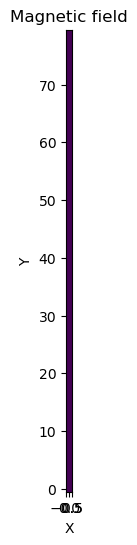

In [133]:
Lx = 1
Ly = 25
dt = 1/np.sqrt(2)/10
quanta = 0
noise = 0

fluxes = quanta*2*pi/(Lx*Ly)*np.ones((Ly,Lx)) + noise*quanta*(np.random.rand(Ly,Lx)-0.5)/(Lx*Ly)
fluxes = fluxes - (np.sum(fluxes)-2*pi*quanta)/(Lx*Ly)
mb.plot_B(fluxes)
a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "Landau")

parameters = dict(
    Lx = Lx,
    Ly = Ly,
    # theta_top = pi-0.01,
    # theta_bot = pi-0.01,
    theta_top = pi,
    theta_bot = pi,
    a_e = a_e,
    a_n = a_n,
    mass = 0,
    kx = 0,
    dt = dt
)


Phi, H, P, deleted_indices = mb.operators_ribbon(parameters)
invphi = np.linalg.inv(Phi.toarray())
Hnl = invphi.conjugate().transpose()@H.toarray()@invphi
identity = np.eye(len(Hnl[0]))

#evolution = np.linalg.inv((P.toarray()-1j*dt/2*H.toarray()))@(P.toarray()+1j*dt/2*H.toarray())
evolution = np.linalg.inv(identity-1j*dt/2*Hnl)@(identity-1j*dt/2*Hnl)

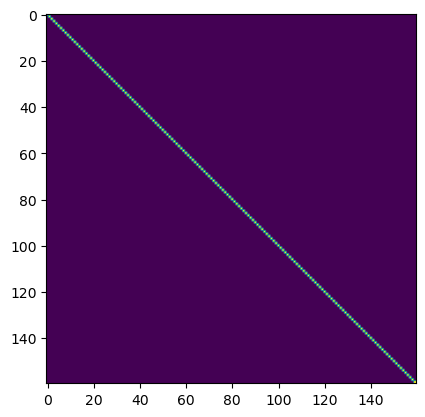

In [134]:
plt.imshow(np.abs(evolution.conjugate().transpose()@evolution))

In [160]:
from scipy.linalg import eigh


def make_td_bands(parameters, number_of_bands = int(20), number_of_points = int(101), kmin = -pi, kmax = pi):
    '''Calculate bands in x direction for the ribbon.'''
    dt = parameters['dt']
    momenta = np.linspace(kmin,kmax, num = number_of_points)
    bands = np.zeros((number_of_points,number_of_bands))
    
    #Solve generalised eigenproblem for all kx
    for j, kx in enumerate(momenta):
        parameters['kx'] = kx
        Phi, H, P, deleted_indices = mb.operators_ribbon(parameters)
        #bands[j] = np.abs(sla.eigsh(P-1j*dt/2*H, M=P+1j*dt/2*H, k = number_of_bands, tol = 1e-7, sigma = 0.0000001, which = 'LM',return_eigenvectors = False))
        #bands[j] = sla.eigs(H, M=P, k = number_of_bands, tol = 1e-7, sigma = 0.0000001, which = 'LM',return_eigenvectors = False)
        h = H.toarray()
        p = P.toarray()
        bands[j] = np.angle(eig(p-1j*dt/2*h, b=p+1j*dt/2*h, right=False)[:number_of_bands])/dt
        # invphi = np.linalg.inv(Phi.toarray())
        # Hnl = invphi.conjugate().transpose()@H.toarray()@invphi
        # identity = np.eye(len(Hnl[0]))
        # bands[j] = np.abs(eig(identity-1j*dt/2*Hnl, b=identity+1j*dt/2*Hnl, right=False)[:number_of_bands])


    return momenta, bands

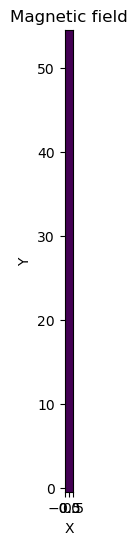

In [166]:
Lx = 1
Ly = 55
quanta = 1
noise = 0

fluxes = quanta*2*pi/(Lx*Ly)*np.ones((Ly,Lx)) + noise*quanta*(np.random.rand(Ly,Lx)-0.5)/(Lx*Ly)
fluxes = fluxes - (np.sum(fluxes)-2*pi*quanta)/(Lx*Ly)
mb.plot_B(fluxes)
a_e, a_n = mb.vector_potential(Lx,Ly,fluxes, gauge = "Landau")

parameters = dict(
    Lx = Lx,
    Ly = Ly,
    # theta_top = pi-0.01,
    # theta_bot = pi-0.01,
    theta_top = pi,
    theta_bot = pi,
    a_e = a_e,
    a_n = a_n,
    mass = 0,
    kx = 0,
    dt = 1/np.sqrt(2)
)


#nbands = 22
Phi, H, P, deleted_indices = mb.operators_ribbon(parameters)
nbands = len(Phi.toarray()[0])
kmin = -pi/Lx
kmax = pi/Lx
momenta, bands = make_td_bands(parameters,number_of_bands = nbands, number_of_points = int(5001), kmin = kmin, kmax = kmax)

(-3.0, 3.0)

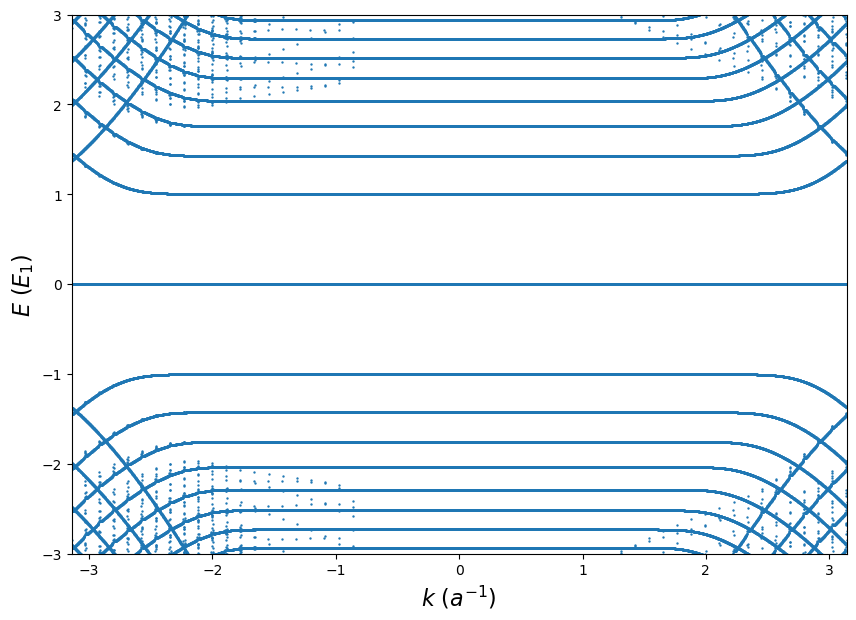

In [168]:
fig = plt.figure(figsize = (10,7))
ax = fig.add_subplot(111)
for i in range(nbands):
    ax.scatter(momenta, bands[:,i]/(np.sqrt((4*pi*quanta/Lx/Ly)) if abs(quanta) >=1  else 1), c = 'C0', s = 0.5)
ax.set_xlabel(r"$k$ $(a^{-1})$",fontsize = 16)
ax.set_xlim(kmin,kmax)
if abs(quanta) < 1:
    ax.set_ylabel(r"$E$ $(\hbar v/a)$",fontsize = 16)
else:
    ax.set_ylabel(r"$E$ $(E_1)$",fontsize = 16)

ax.set_ylim(-3,3)

In [79]:
## Why are the eigenvalues close to unit modulus???